# Localization Assignment



## Getting Set Up
You should have cloned the GitHub Classroom link to receive the deliverables
for this project.


In [1]:
# Run and do not edit this magic cell. 
# It helps getting things to work throughout the Jupyter notebook - in particular importing changes in functions made in files other than this workspace.

%load_ext autoreload
%autoreload 2


## Particle Filter
First, you will complete a series of quick exercises which will guide you through implementing a simplified particle filter. You will be given two files:

    student_particle_filter.py
    animate_particle_filter.py

In `student_particle_filter` you will implement a particle filter which causes a set of randomly generated points on a 2d plane to converge on a specific point. `student_particle_filter` will write the particles' poses to a text file, which will be read and used to generate an animation.

Detailed instructions for each step are in the comments of `student_particle_filter`.

### 1. Setup

Define a `Particle` class to represent the particles in the filter. Each particle should store its position ($x$,$y$) and its weight.

Define a `ParticleSet` class to store the set of particles, the desired pose, and the methods which operate on the particle set.  Create an `__init__` method which takes the number of particles as input and creates a set of particles at random positions.

### 2. Motion

Implement a method for the `ParticleSet` class which adds some random Gaussian noise to the $x$ and $y$ positions of each particle in the filter. Be sure that the noise is different for each particle.

*Hint:* try `numpy.random.normal`.

### 3. Measurement Update

Implement a method for the `ParticleSet` class which sets the weight of each particle inversely proportional to the particle's distance from the desired pose.

### Testing your code

Try running your code! If it works properly, the particle poses should be written to a file
called `particle_filter_data.txt`. You can then run the cells below to view
an animation of your particle filter converging on the desired pose which you set.


In [2]:
# TODO: modify <yourGitHubName> to make this the path to your exercise folder
EXERCISE_DIRECTORY = "/code/dd21-localization-lx/packages/project-localization-slam-2019-Tuxliri/"
import sys

sys.path.append(EXERCISE_DIRECTORY)

POSES_FILE_NAME = 'particle_filter_data.txt'
POSES_FILE_PATH = EXERCISE_DIRECTORY + POSES_FILE_NAME

NUM_PARTICLES = 100

In [3]:
from student_particle_filter import ParticleSet

particles = ParticleSet(NUM_PARTICLES)

try:
    pp = open(POSES_FILE_PATH, 'w')
    for _ in range(800):
        particles.particle_motion()
        particles.weight_particles()
        particles.resample_particles()

        for i in range(particles.p_list_weight.size):
            pp.write(str(particles.p_list_x[i]) +
                     '\n' + str(particles.p_list_y[i]) + '\n')
finally:
    pp.close()

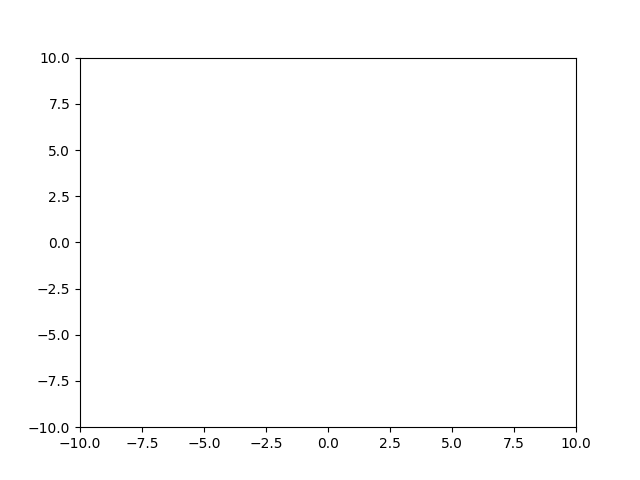

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
# from IPython.display import HTML
import ipywidgets as widgets

from particle_filter.animate_particle_filter import read_pose_file

%matplotlib widget

fig, ax = plt.subplots()
poses = read_pose_file(POSES_FILE_PATH,NUM_PARTICLES)

line, = ax.plot([], [], 'bo',)

ax.set_xlim(-10,10)
ax.set_ylim(-10, 10)

def animate(i,particles_trajectories,line):
    particles_poses = particles_trajectories[i]
    x_list = [pose[0] for pose in particles_poses]
    y_list = [pose[1] for pose in particles_poses]

    line = line.set_data(x_list,y_list)
    return (line,)

ani = FuncAnimation(fig,partial(animate,particles_trajectories=poses,line=line),frames=100,)

plt.show()


### Optimizing the code

Now that your filter is running, let's consider how we can optimize this process so that the localization particle filter will run quickly in real time on your drones.
Python data structures and their operations are relatively slow compared to their Numpy counterparts because Numpy is written in C. You will use Numpy arrays to avoid storing the set of particle poses and their weights as lists of Python objects. You may comment out the `Particle` class entirely and replace the list of particle objects with two Numpy arrays for poses and weights stored in the `ParticleSet` class. Adjust the rest of the code accordingly.


## OpenCV

Now we that know the basics of how a particle filter uses weights and resampling to converge on a target, we need to address how to use OpenCV to estimate the motion and global position of the flying drone. To do this, you will complete the cells in this notebook using OpenCV functions to compute the translation in the plane between two drone poses, represented by two overlapping images taken on a real drone. You will be provided with the following files:

    image_A.jpg
    image_B.jpg
    student_compute_displacement.py

Keep in mind that the real-world dimensions of a pixel in the image will vary based on the height of the drone. Why is this?

Your job is to write code in that will extract features from both images and compute a transformation between them. Use this transformation to compute the $x$,$y$, and yaw displacement *in meters* between the two images. This is exactly how you will implement the motion model for localization: we consider the meter displacement between two drone images to be the motion of the drone between the poses at which the images were taken.

In this task, you will use OpenCV to implement the motion
model for localization and SLAM on the drone. This involves computing the
distance between overlapping camera frames taken by the drone as it flies.

In this task, you will be expected to read OpenCV documentation in order to
use the various functions properly. Please visit the [documentation](https://docs.opencv.org/3.4/index.html) and use the search bar to locate
the indicated functions.

In [5]:

import cv2
import numpy as np
import math

image_A = cv2.imread('/code/dd21-localization-lx/assets/opencv/img_A.jpg')
image_B = cv2.imread('/code/dd21-localization-lx/assets/opencv/img_B.jpg')



### 1. Extract Features

In this step, we extract the coordinates of salient features from each image,
called keypoints, as well as descriptors of those features. Look at the `detectAndCompute` function in OpenCV's documentation [here](https://docs.opencv.org/4.7.0/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677).

*Hint*: kp are keypoints, des are descriptors. Remember that each feature is
described by a kp and a des.

*Hint 2*: you may use `None` as the `mask` argument


Text(0.5, 1.0, 'Features in Image B')

<Figure size 800x600 with 0 Axes>

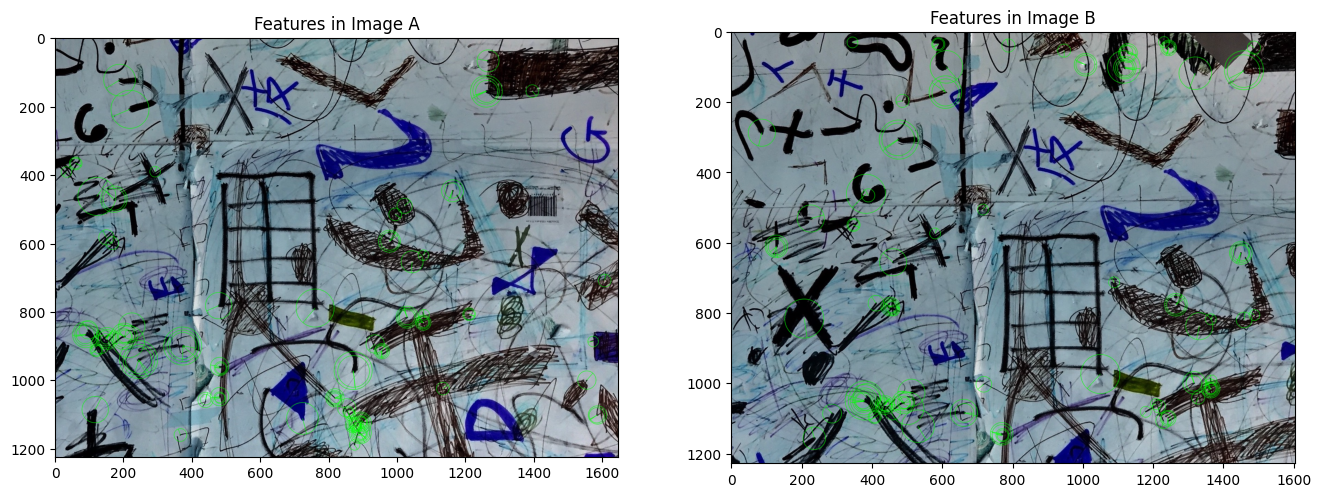

No such comm: ddea8c6845204b8aad93534e1186dd07


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# TODO: use detector.detectAndCompute() (called ORB::Operator() in the documentation),
# to extract keypoints and descriptors from both images
plt.clf()

NUM_FEATURES = 100
detector = cv2.ORB.create(nfeatures=NUM_FEATURES, scoreType=cv2.ORB_FAST_SCORE)

aKeyPoints, aDescriptors = detector.detectAndCompute(image_A, None)
bKeyPoints, bDescriptors = detector.detectAndCompute(image_B, None)

# Show the keypoints
image_A_annotated = cv2.drawKeypoints(image_A, aKeyPoints, None, color=(0,255,0),flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_B_annotated = cv2.drawKeypoints(image_B, bKeyPoints, None, color=(0,255,0),flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig,(ax1, ax2), = plt.subplots(1,2,figsize=(16, 12))
ax1.imshow(image_A_annotated)
ax1.set_title("Features in Image A")
ax2.imshow(image_B_annotated)
ax2.set_title("Features in Image B")


### 2. Match Features and Descriptors

In this step, we compare the descriptors of features in each image to
to find the features in each image which describe the same point.

Search for `Descriptor Matcher` in the OpenCV documentation.

Some questions to think about (your knowledge of these may be checked during a project checkoff):

- How is the list of matches formatted?
- What kind of objects are in the list?
- What fields do they have?
- Decide on a value for the parameter `k`. Why did you pick that value? (It may be helpful to do the rest of the comments in this step before answering this question.)

Text(0.5, 1.0, 'Matched Keypoints')

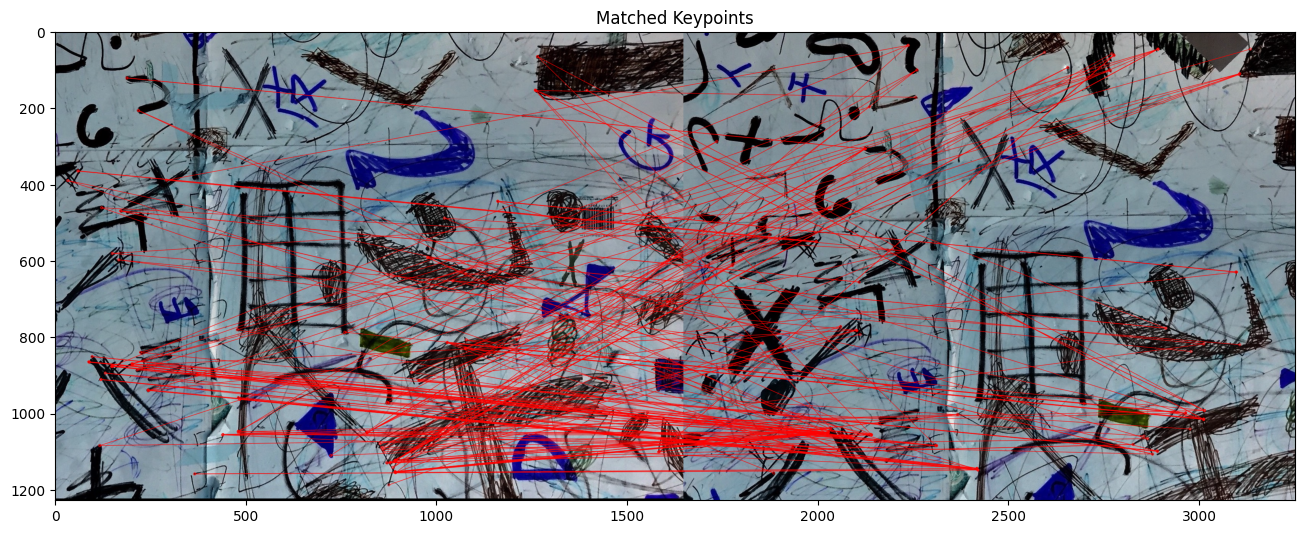

In [18]:
import cv2

index_params = dict(algorithm=6, table_number=6,
                    key_size=12, multi_probe_level=1)
search_params = dict(checks=50)

matcher = cv2.FlannBasedMatcher(index_params, search_params)

# TODO: use knnMatch to obtain the list of matches between the image_A
# descriptors and the image_B descriptors
matchesList = matcher.knnMatch(aDescriptors, bDescriptors, k=2)

fig1,ax, = plt.subplots(figsize=(16, 12))

# Show the best 10 matched keypoints
image_matches = cv2.drawMatchesKnn(image_A, aKeyPoints, image_B, bKeyPoints, matchesList, None, matchColor=(255,0,0),flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
ax.imshow(image_matches)
ax.set_title('Matched Keypoints')


Now, we will filter out the poor matches from the matches list

*Hint*: a large distance between descriptors means a poor match, and a small
distance indicates a strong match

*Hint 2*: `knnMatch` finds the k best matches in the second input list for each
descriptor in the first input list. Compare the best matches for each descriptor
to judge the quality of a match. What does it mean when the best match is
similar in quality to the second best match? What does it mean when the best
match is much better than the second best match?

Apply the ratio test, as per Lowe's paper:
[Source 1](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf#page=20)
[Source 2](https://docs.opencv.org/3.3.0/dc/dc3/tutorial_py_matcher.html)


Then, we will recover the coordinates in each image of the
features we have just matched. Each match corresponds to two features: one in
`image_A`, and one in `image_B`, which both describe the same point.

Some questions to think about (your knowledge of these may be checked during a project checkoff):

- Search `Keypoint` in the documentation to find details on the keypoint object.
- What field does the keypoint object have to hold feature coordinates?


In [19]:

# TODO: filter the matches based on their quality.

good = []
for m in matchesList:
    # a few places in the list where I would expect a pair of matches there isn't a pair and that breaks things
    if len(m) == 2:
        if m[0].distance < 0.75*m[1].distance:
            good.append(m[0])

# TODO: Obtain lists of the keypoint coordinates from both image A and image B
# for each of the filtered matches.

image_A_match_good_keypoints = np.array([])
image_B_match_good_keypoints = np.array([])

for g in good:
    image_A_match_good_keypoints = np.append(
        image_A_match_good_keypoints, aKeyPoints[g.queryIdx])
    image_B_match_good_keypoints = np.append(
        image_B_match_good_keypoints, bKeyPoints[g.trainIdx])

# print(image_A_match_good_keypoints)
# print(image_B_match_good_keypoints)


image_A_match_keypoints = cv2.KeyPoint_convert(image_A_match_good_keypoints)
image_B_match_keypoints = cv2.KeyPoint_convert(image_B_match_good_keypoints)




### 3. Estimate the Transform
In this step, we will use the lists of coordinates of the matching features
from each image to compute a transformation between the two pictures.


Use `estimateRigidTransform` or  `estimateAffinePartial2D` to find the transformation between `imageA_points` and `imageB_points`.

*Tip*: Search `estimate transform` in the documentation.

*Hint*: the 3rd argument to `estimateRigidTransform` should be `False`


In [22]:

imageA_points = np.float32(image_A_match_keypoints).reshape(-1, 1, 2)
imageB_points = np.float32(image_B_match_keypoints).reshape(-1, 1, 2)

transform = cv2.estimateAffinePartial2D(imageA_points, imageB_points)[0]
transform1 = cv2.estimateRigidTransform(imageA_points, imageB_points, False)

print(transform)
print(transform1)


[[ 1.00022844e+00  3.99059405e-04  2.87701847e+02]
 [-3.99059405e-04  1.00022844e+00  1.85441094e+02]]
[[ 1.00028709e+00  2.39863345e-04  2.87703658e+02]
 [-2.39863345e-04  1.00028709e+00  1.85236985e+02]]



### 4. Convert to Meters
In this step we will use the height of the drone to convert the pixel displacement
from the transformation to meters.

To do this, we multiply the height (meters) by a specific camera scale to obtain
the meter-per-pixel value of the camera. This number varies with the height
of the drone. Then, we can multiply this ratio by the pixel displacement (what you
just computed) to find the meter displacement.

Some questions to think about (your knowledge of these may be checked during a project checkoff):

- What unit must the camera scale have?
- How might you experimentally determine the camera scale for the drone's camera?
- Bonus question: how might you mathematically determine the scale?

In [23]:

# transform = <transformation computed with estimateRigidTransform >
x_displacement = -transform[0, 2]
y_displacement = transform[1, 2]
yaw_displacement = -np.arctan2(transform[1, 0], transform[0, 0])

# Compute the meter distance between the two image frames

scale = 0.23/290
print(x_displacement*scale)
print(y_displacement*scale)
print(yaw_displacement)

-0.2281773266830772
0.14707397099944625
0.00039896824343690874



## Implement Localization on the Duckiedrone

[TODO: TEST] 

We are now ready to implement localization on the drone.

You will be given two files:

    student_run_localization.py
    student_localization_helper.py

`student_run_localization` runs localization on the drone and is complete, you will not need to implement any code in that file. However, you may adjust the `NUM_PARTICLE` and `NUM_FEATURE` values to experiment with the speed/accuracy tradeoff concerning the number of particles in the filter and the number of features extracted by OpenCV. You may also edit this file if you need to change the map over which you want to localize.

`student_localization_helper.py` contains the particle filter class and its methods. Many of the methods are not implemented. The docstrings describe the intended functionality of each function, and the `TODOs` indicate tasks to be completed. Your assignment is to follow the `TODOs` and implement the missing functionality of the particle filter. Much of the code you just wrote can be used here!

__Tip__: we recommend that you read through the parts of the code which we are not asking you to implement,
as this will help you to understand what is going on with the code and will likely save you
debugging time. For example, we are not asking you to implement the methods `resample_particles` or `initialize_particles`
for localization, but it might help you to understand how they work! The same goes for the SLAM project.

Note that for both this part of the assignment and for SLAM, there is not any "correct" universal
implementation of the code as long as your solutions work.


## Getting Set Up

To run the porject on the drone, clone your repository (`project-localization-slam-2019-<yourGitHubUsername>`) in the `/catkin_ws/src` folder
on your drone. 

You should find the `package.xml` and `CMakeLists.txt` files which you will need to modify
to build the package:

- On line `3` of `package.xml` you should replace
`yourGithubName` with your GitHub name so it matches the name of your directory. 
- Do the same on line `2` of `CMakeLists.txt` 

Finally, you should navigate to the `/catkin_ws` folder and run:

    catkin_make --pkg project-localization-slam-2019-yourGithubName

to build your package so it is ros-runnable by `pidrone_pkg`. You should only need to
do this step one time.




### Testing
To test the functionality of your localization code, you may fly the drone while running

    rosrun project_localization_slam_2019_<yourGithubName> student_run_localization.py

in the vision screen. 

It is easiest to take photos of the new map with a cell phone or other camera. Take them at a height of 25cm and use an image stitching software to generate the map. We recommend auto-stitch. Replace `map.jpg` with your new map and change the following four parameters in `student_run_localization.py`, `student_localization_helper.py`: `MAP_PIXEL_WIDTH`, `MAP_PIXEL_HEIGHT`, `MAP_REAL_WIDTH`, `MAP_REAL_HEIGHT`. You may need to resize the image to be smaller if it is too large.

You should see poses printed out which correspond to the drone's position over the map.

You may also use the visualization functions in [the previous sections](#particle-filter) to visualize the animation of your particle filter. Print the ($x$,$y$) pose of each particle on separate lines in a text file to point at using the variable `POSES_FILE_NAME`. Make sure you adjust `NUM_PARTICLES` to reflect the number of particles you are using! (using the visualizer is optional)

### Checkoff
We will verify that your code has the following functionality:

 1. You can run `student_run_localization.py` and take off with your drone.
 2. While flying, you can hit 'r' and the poses will begin printing to the terminal. You can hit 'r' again and localization will restart.
 3. While flying, you can hit 'p' to toggle position hold on and off.
 4. Run `student_run_localization.py` while holding the drone over a mapped area. Do not arm the drone. As you move the drone around, verify that the poses reflect the movement. Verify visually that the poses are close to the actual position of the drone in the map. For example, if you are holding the drone above the bottom left corner of the mapped area, the pose should be close to (0,0).